## Sequence-to-Sequence LSTM: Predicting the Second Sentence (GloVe)

The LSTM model implemented in this repo draws from the [Sequence to Sequence Learning with Neural Networks (2014)](https://arxiv.org/pdf/1409.3215) paper from 2014 written by Google researchers Ilya Sutskever, Oriol Vinyals, and Quoc V. Le. The original paper uses an encoder/decoder LSTM model to convert English to French. Ben Trevett, an NLP engineer, implemented a similar but simplified seq-2-seq model based on the Google paper. There are many code segments that I'm using from Ben's implementation that can be found in his GitHub repo [here](https://github.com/bentrevett/pytorch-seq2seq).

The main difference between my code and Ben's code is that I'll be implementing a version of `nn.LSTM` myself, rather than using pytorch's pre-built implementation. Some additional differences in my implementation:

- Source vocabulary and target vocabulary are identical (as nothing is being translated)
- Doing all dataset creation/preprocessing myself
- Running everything on CPU vs. GPU

I also found a handful of other articles/videos really useful:

- [PyTorch LSTM documentation]("https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html"): This was useful in understanding what my LSTMCell class needed to have in order to function with my Encoder, Decoder, and S2S classes as well as working with PyTorch's autodifferentiation, SGD, and cross entropy loss functions.

- [StatQuest YouTube Channel]("https://www.youtube.com/watch?v=L8HKweZIOmg&t=24s&ab_channel=StatQuestwithJoshStarmer"): StatQuest YouTube channel has a bunch of videos on sequence to sequence problems, which helped with the intuitive understanding. He also has videos that implement seq-2-seq using PyTorch Lightning. He follow's Ben's repository as well.

- [Mustafa Murat ARAT Blog]("https://mmuratarat.github.io/2019-01-19/dimensions-of-lstm"): This article was helpful in understanding the dimensionality of weights/biases


#### Imports:

In [1]:
import torch
import torch.nn as nn
import random
import numpy as np
import torch.optim as optim
import tqdm
import evaluate

EMBED_SIZE = 200

/home/will/miniconda3/envs/pycourse/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/will/miniconda3/envs/pycourse/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/will/miniconda3/envs/pycourse/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#### Set all random seeds (for testing purposes, will remove):

In [2]:
#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#torch.manual_seed(seed)

#### Pre-process the Training Data

training_firsts (and seconds) will be a lists of length 6036 each. Each element of these lists is a sentence vector, where each element corresponds to the words in the sentence. both `<s>` and `</s>` are included in each sentence vector. 

In [3]:
# TRAINING
training_size = 6036
training_firsts = []
training_secs = []
with open("bobsue-data/bobsue.seq2seq.train.tsv") as trainfile:
    for line in trainfile:
        separated = line.split()
        for i in range(len(separated)):
            if separated[i] == "</s>":
                sent1 = separated[:i + 1]
                sent2 = separated[i + 1:]
                break
        training_firsts.append(sent1)
        training_secs.append(sent2)


Now, we repeat for validation and testing sets:

In [4]:
# VALIDATION
validation_size = 750
valid_firsts = []
valid_secs = []
with open("bobsue-data/bobsue.seq2seq.dev.tsv") as valfile:
    for line in valfile:
        separated = line.split()
        for i in range(len(separated)):
            if separated[i] == "</s>":
                sent1 = separated[:i + 1]
                sent2 = separated[i + 1:]
                break
        valid_firsts.append(sent1)
        valid_secs.append(sent2)

# TESTING
testing_size = 750
test_firsts = []
test_secs = []
with open("bobsue-data/bobsue.seq2seq.test.tsv") as testfile:
    for line in testfile:
        separated = line.split()
        for i in range(len(separated)):
            if separated[i] == "</s>":
                sent1 = separated[:i + 1]
                sent2 = separated[i + 1:]
                break
        test_firsts.append(sent1)
        test_secs.append(sent2)


#### Generating Embeddings: GloVe

We now have to give each word in our target vocabulary an embedding. To do this, we'll use GloVe. I'll be using snippits from [Martín Pellarolo’s Blog](https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76) in my implementation. `word_2_index` maps each word in the GloVe file to an index (i.e. 0, 1, ...). Associated with each index is the corresponding entry in `embeddings_vector`. `embeddings_vector` has shape `(size of glove vocabulary, EMBED_SIZE)`. `glove_voc` stores each word in the GloVe vocabulary. Lastly, we'll create a dictionary `glove` that has keys that are vocabulary words, and the values are the corresponding embedding vectors. 

In [5]:
#GloVe
#See descriptions above for the below three variables
word_to_index = {}
embeddings_vector = []
glove_voc = []

index = 0
with open(f'embedding-data/glove.6B.{EMBED_SIZE}d.txt') as embedfile:
    for line in embedfile:
        #Store the first element of the line as the word, store the remaining elements as the embedding vector of size EMBED_SIZE
        split_vector = line.split()
        cur_embedded_word = split_vector[0]
        
        cur_embedded_vector = np.array(split_vector[1:]).astype(np.float32)
        word_to_index[cur_embedded_word] = index

        glove_voc.append(cur_embedded_word)
        embeddings_vector.append(cur_embedded_vector)
        index += 1

glove = {w: embeddings_vector[word_to_index[w]] for w in glove_voc}
index_to_add = index

We'll generate our target vocabulary from our `bobsue.voc.txt` file

In [6]:
#Pre-process target vocabulary
target_voc = []
with open('bobsue-data/bobsue.voc.txt') as vocfile:
    for line in vocfile:
        line = line.split()
        target_voc.append(line[0])
target_voc = np.array(target_voc)

The next step is to ensure that we have embeddings for all words in our target vocabulary. To do this, we'll loop through each word in `target_voc`, and if the word appears in our glove dictionary with an embedding, we link that same embedding in the new `target_embeddings` dictionary. If not, we assign a normally distributed random vector of dimension EMBED_SIZE. `target_voc` is a `numpy` array where each element is a word that appears in our training/testing data.

In [7]:
tgt_vocab_len = len(target_voc)
target_embeddings = {}
for i in range(tgt_vocab_len):
    cur_word = target_voc[i]
    if cur_word in glove:
        target_embeddings[cur_word] = glove[cur_word]
    else:
        target_embeddings[cur_word] = np.random.normal(scale=0.6, size=(EMBED_SIZE, ))
        word_to_index[cur_word] = index_to_add
        index_to_add += 1

Create a dictionary `target_to_index` from a target word to its corresponding index (does the inverse of calling `target_voc[i]`). Then, we'll define `tokenized_to_indices` to convert a tokenized sentence into a list of integers corresponding to the index in our vocabulary.

In [8]:
target_to_index = {}
index_to_target = {}
index_to_embedding = []
for i, word in enumerate(target_voc):
    target_to_index[word] = i
    index_to_target[i] = word

for i in range(len(target_voc)):
    target = index_to_target[i]
    embedding = target_embeddings[target]
    index_to_embedding.append(embedding)

index_to_embedding = np.array(index_to_embedding)
index_to_embedding = torch.from_numpy(index_to_embedding).float()


In [9]:
def tokenized_to_indices(tokens):
    indices = []
    for i in range(len(tokens)):
        indices.append(target_to_index[tokens[i]])
    return indices

We need to convert all of our training sentences into tensors of numerical embeddings. First we'll write a function that takes a tokenized sentence and outputs the corresponding tensor.

In [10]:
def sent_to_embed(tokenized_seq):
    """
    Given a tokenized sentence (where tokenized seq is a vector of tokens for a given sentence),
    returns the a vector where each element corresponds to the embedding of that word
    """
    embeddings = []
    for token in tokenized_seq:
        cur_embedding = target_embeddings[token]
        embeddings.append(cur_embedding)
    embeddings = np.array(embeddings)
    embeddings = torch.from_numpy(embeddings).float()
    return embeddings


### Aggregating our data:
Now, we'll create full datasets for training, validation, and testing.

In [11]:
#Training Data
training_data = []
for i in range(len(training_firsts)):
    cur_pair_data = {
        'src_tokens' : training_firsts[i],
        'tgt_tokens' : training_secs[i],

        'src_len' : len(training_firsts[i]),
        'tgt_len' : len(training_secs[i]),

        'src_indices' : torch.tensor(tokenized_to_indices(training_firsts[i]), dtype=torch.int16),
        'tgt_indices' : torch.tensor(tokenized_to_indices(training_secs[i]), dtype=torch.int16),

        'src_embeddings' : sent_to_embed(training_firsts[i]),
        'tgt_embeddings' : sent_to_embed(training_secs[i])
        }
    training_data.append(cur_pair_data)

We'll repeat the process for validation and testing:

In [12]:
#VALIDATION DATA
validation_data = []
for i in range(len(valid_firsts)):
    cur_pair_data = {
        'src_tokens' : valid_firsts[i],
        'tgt_tokens' : valid_secs[i],

        'src_len' : len(valid_firsts[i]),
        'tgt_len' : len(valid_secs[i]),

        'src_indices' : torch.tensor(tokenized_to_indices(valid_firsts[i]), dtype=torch.int16),
        'tgt_indices' : torch.tensor(tokenized_to_indices(valid_secs[i]), dtype=torch.int16),

        'src_embeddings' : sent_to_embed(valid_firsts[i]),
        'tgt_embeddings' : sent_to_embed(valid_secs[i])
        }
    validation_data.append(cur_pair_data)

In [13]:
#TESTING DATA
testing_data = []
for i in range(len(test_firsts)):
    cur_pair_data = {
        'src_tokens' : test_firsts[i],
        'tgt_tokens' : test_secs[i],

        'src_len' : len(test_firsts[i]),
        'tgt_len' : len(test_secs[i]),

        'src_indices' : torch.tensor(tokenized_to_indices(test_firsts[i]), dtype=torch.int16),
        'tgt_indices' : torch.tensor(tokenized_to_indices(test_secs[i]), dtype=torch.int16),

        'src_embeddings' : sent_to_embed(test_firsts[i]),
        'tgt_embeddings' : sent_to_embed(test_secs[i])
        }
    testing_data.append(cur_pair_data)

### Building the Model
We've now prepared our training, validation, and testing data. We now need to build the LSTM model, Encoder, and Decoder.

In [14]:
from model import Encoder, Decoder, S2S

#See model.py for encoder, decoder, and seq-2-seq classes

encoder = Encoder(EMBED_SIZE, EMBED_SIZE)
decoder = Decoder(EMBED_SIZE, EMBED_SIZE, index_to_embedding)
s2s = S2S(encoder, decoder)

Initalize weights: the paper uses uniform between -0.08 and 0.08. Set up optimizer and loss functions: I'm using SGD and cross entropy loss.

In [15]:
def init_weights(model):
    for name, parameter in model.named_parameters():
        nn.init.uniform_(parameter.data, -0.08, 0.08)

### Training the Model

Training Loop:

In [16]:
def train_fn(model, optimizer, criterion, training_data):
    model.train()
    epoch_loss = 0
    for i in range(len(training_data)):
        src = training_data[i]['src_embeddings']
        tgt = training_data[i]['tgt_embeddings']
        
        optimizer.zero_grad()
        output = model(src, tgt, tf=True)
        
        loss = criterion(output, tgt)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss/len(training_data)

Evaluation Loop: (no updating parameters)

In [17]:
def eval_fn(model, criterion, val_data):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i in range(len(val_data)):
            src = val_data[i]['src_embeddings']
            tgt = val_data[i]['tgt_embeddings']

            output = model(src, tgt, tf=False)

            loss = criterion(output, tgt)
            epoch_loss += loss.item()
    
    return epoch_loss/len(val_data)

Model Training:

In [18]:
s2s.apply(init_weights)
optimizer = optim.Adam(s2s.parameters())
criterion = nn.MSELoss()

n_epochs = 20
best_valid_loss = float("inf")

#Testing with subsets
#subset_size = 1000
#train_subs = training_data[:subset_size]
#valid_subs = validation_data[:subset_size]

training_losses = []
valid_losses = []

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(s2s, optimizer, criterion, training_data)
    valid_loss = eval_fn(s2s, criterion, validation_data)

    training_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"\tTrain Loss: {train_loss}")
    print(f"\tValid Loss: {valid_loss}")
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(s2s.state_dict(), "saved_lstm.pt")   

  5%|▌         | 1/20 [01:43<32:52, 103.80s/it]

	Train Loss: 0.059157409704913066
	Valid Loss: 0.05026989179352919


 10%|█         | 2/20 [03:30<31:33, 105.22s/it]

	Train Loss: 0.04893108741537655
	Valid Loss: 0.04828341976801554


 15%|█▌        | 3/20 [05:16<29:59, 105.83s/it]

	Train Loss: 0.04794279675599931
	Valid Loss: 0.04776681796709696


 20%|██        | 4/20 [07:00<27:58, 104.89s/it]

	Train Loss: 0.04763406341755979
	Valid Loss: 0.04757076784968376


 25%|██▌       | 5/20 [08:40<25:48, 103.25s/it]

	Train Loss: 0.04748524116374419
	Valid Loss: 0.047481027737259866


 30%|███       | 6/20 [10:21<23:53, 102.42s/it]

	Train Loss: 0.04738808896039558
	Valid Loss: 0.04738709632555644


 35%|███▌      | 7/20 [12:01<22:01, 101.63s/it]

	Train Loss: 0.04732165133118916
	Valid Loss: 0.0473444341023763


 40%|████      | 8/20 [13:41<20:13, 101.09s/it]

	Train Loss: 0.04726258885995482
	Valid Loss: 0.047285620853304865


 45%|████▌     | 9/20 [15:21<18:30, 100.95s/it]

	Train Loss: 0.04721500482650892
	Valid Loss: 0.04725031095246474


 50%|█████     | 10/20 [17:03<16:50, 101.09s/it]

	Train Loss: 0.04717592060574589
	Valid Loss: 0.047218078901370364


 55%|█████▌    | 11/20 [18:47<15:19, 102.15s/it]

	Train Loss: 0.047141745929699455
	Valid Loss: 0.0472043066372474


 60%|██████    | 12/20 [20:30<13:38, 102.28s/it]

	Train Loss: 0.04687044026319004
	Valid Loss: 0.046731114817162356


 65%|██████▌   | 13/20 [22:09<11:49, 101.42s/it]

	Train Loss: 0.046610515348358986
	Valid Loss: 0.04663040307660898


 70%|███████   | 14/20 [23:53<10:13, 102.25s/it]

	Train Loss: 0.046248969683674215
	Valid Loss: 0.046328865061203636


 75%|███████▌  | 15/20 [25:36<08:31, 102.37s/it]

	Train Loss: 0.04620483966243087
	Valid Loss: 0.04630450704693794


 80%|████████  | 16/20 [27:22<06:53, 103.36s/it]

	Train Loss: 0.04618294086959028
	Valid Loss: 0.04630391713231802


 85%|████████▌ | 17/20 [29:07<05:11, 103.80s/it]

	Train Loss: 0.04616702653250408
	Valid Loss: 0.04627045062184334


 90%|█████████ | 18/20 [30:52<03:28, 104.35s/it]

	Train Loss: 0.04615477141489092
	Valid Loss: 0.04626375678678354


 95%|█████████▌| 19/20 [32:34<01:43, 103.54s/it]

	Train Loss: 0.046140356810184566
	Valid Loss: 0.04626894733309746


100%|██████████| 20/20 [34:11<00:00, 102.59s/it]

	Train Loss: 0.046128062426123086
	Valid Loss: 0.04624654256800811


In [19]:
def convert_to_english(embeddings, index_to_embedding, index_to_target):
    tokens = []
    for i in range(len(embeddings)):
        minimum = np.Inf
        minimum_index = -1
        for j in range(len(index_to_embedding)):
            if torch.norm(index_to_embedding[j] - embeddings[i]) < minimum:
                minimum = torch.norm(index_to_embedding[j] - embeddings[i])
                minimum_index = j
        tokens.append(index_to_target[minimum_index])
    
    return tokens

In [20]:
def test(model, test_data, index_to_embedding, index_to_target):
    model.eval()
    epoch_loss = 0
    predicted_tokens = []
    actual_tokens = []
    with torch.no_grad():
        for i in tqdm.tqdm(range(len(test_data))): #TODO::: CHANGE MEEEE
            src = test_data[i]['src_embeddings']
            tgt = test_data[i]['tgt_embeddings']

            output = model(src, tgt, tf=False)
            predicted_tokens.append(convert_to_english(output, index_to_embedding, index_to_target))
            actual_tokens.append(convert_to_english(test_data[i]['tgt_embeddings'], index_to_embedding, index_to_target))

            loss = criterion(output, tgt)
            epoch_loss += loss.item()
    
    return epoch_loss/len(test_data), predicted_tokens, actual_tokens

test_loss, predictions_tokens, actuals_tokens = test(s2s, testing_data, index_to_embedding, index_to_target)

  0%|          | 0/750 [00:00<?, ?it/s]

100%|██████████| 750/750 [02:26<00:00,  5.10it/s]


Plotting Train/Validation error as a function of epoch:

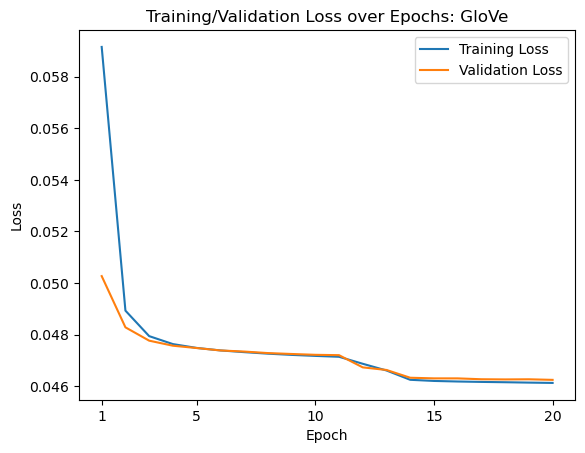

In [21]:
import matplotlib.pyplot as plt
epochs_x = np.arange(n_epochs, dtype=int) + 1
xticks = [1]
for i in range(2, n_epochs + 1):
    if i % 5 == 0:
        xticks.append(i)

fig, ax = plt.subplots()
ax.plot(epochs_x, training_losses, label="Training Loss")
ax.plot(epochs_x, valid_losses, label="Validation Loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax.set_title("Training/Validation Loss over Epochs: GloVe")
ax.set_xticks(xticks)
ax.legend()


Let's generate some sample sentence predictions/actual output pairs: First, we'll define a function to convert a list of tokens to a string sentence

In [22]:
def tokens_to_string(tokens):
    str = ""
    for token in tokens:
        str += token + " "
    return str

Now, we can compare predictions and testing outputs:

In [23]:
for j in range(8):
    i = j * 100
    #so we can look at 0, 100, 200, 300, 400, 500, 600, 700th test pairs
    test_input = tokens_to_string(testing_data[i]['src_tokens'])
    testing_actual = tokens_to_string(actuals_tokens[i])
    test_prediction = tokens_to_string(predictions_tokens[i])
    

    print(f"Example {j + 1} (test sample {i + 1}):")
    print(f"Input sentence: {test_input}")
    print(f"Correct response: {testing_actual}")
    print(f"Predicted response: {test_prediction}")

    print()


Example 1 (test sample 1):
Input sentence: <s> Sue ended up being very good . </s> 
Correct response: <s> Sue stuck with dance and loved it . </s> 
Predicted response: <s> Sue stuck with dance and loved it . </s> 

Example 2 (test sample 101):
Input sentence: <s> The wind was getting very bad by Bob 's house . </s> 
Correct response: <s> Bob went in to check the weather report . </s> 
Predicted response: <s> Bob went in to check the weather report . </s> 

Example 3 (test sample 201):
Input sentence: <s> Sue was walking to the store . </s> 
Correct response: <s> She noticed someone near her on the sidewalk . </s> 
Predicted response: <s> She noticed someone near her on the sidewalk . </s> 

Example 4 (test sample 301):
Input sentence: <s> Bob got up in the morning , all ready for his first class . </s> 
Correct response: <s> Before he left , he realized he didn 't have his phone . </s> 
Predicted response: <s> Before he left , he realized he didn chose have his phone . </s> 

Example 5

Sending all predictions to predictions_glove.txt

In [24]:
with open("predictions_glove.txt", "w") as outfile:
    for j in range(len(testing_data)):
        cur_pred_tokens = predictions_tokens[j]
        cur_prediction = tokens_to_string(cur_pred_tokens) + "\n"
        outfile.write(cur_prediction)

Let's now see how many predictions are different than the output:

In [25]:
incorrect_indices = []
for i in range(len(actuals_tokens)):
    if actuals_tokens[i] != predictions_tokens[i]:
        
        incorrect_indices.append(i)
len(incorrect_indices)

print(incorrect_indices[0])

2


Output the incorrect sequences and compare to the correct sentences:

In [26]:
with open("incorrect_predictions_glove.txt", "w") as incorrectfile:
    for j in range(len(incorrect_indices)):
        incorrect_index = incorrect_indices[j]
        correct = tokens_to_string(actuals_tokens[incorrect_index]) + "\n"
        prediction = tokens_to_string(predictions_tokens[incorrect_index]) + "\n"

        incorrectfile.write(f"Test line: {incorrect_index + 1}\n")
        incorrectfile.write(f"Correct output: {correct}")
        incorrectfile.write(f"Predicted output: {prediction}\n")


Now that we know the indices on the test set where we were incorrect, we can find which words were correct/wrong the most

In [27]:
def compare_tokens(prediction, actual, correct_usage):
    """
    Compares the tokens between prediction and actual sentences (both lists of tokens), increments 'correct' or 'incorrect' values
    for that token. We increment based on the actual word, not the prediction
    """
    for i in range(len(prediction)):
        pred_token = prediction[i]
        act_token = actual[i]
        
        if pred_token == act_token:
            correct_usage[act_token]['correct'] += 1
        else:
            correct_usage[act_token]['incorrect'] += 1

        correct_usage[act_token]['appearances'] += 1
    
    return correct_usage

In [28]:
correct_usage = {}
for token in target_voc:
    token_dict = {}
    token_dict['correct'] = 0
    token_dict['incorrect'] = 0
    token_dict['appearances'] = 0

    #We'll update these after calculating the above 3
    token_dict['correct_rate'] = -1
    token_dict['incorrect_rate'] = -1
    correct_usage[token] = token_dict

Now, we go through each testing pair to see how each word performed

In [29]:
for i in range(len(actuals_tokens)):
    prediction = predictions_tokens[i]
    actual = actuals_tokens[i]
    correct_usage = compare_tokens(prediction, actual, correct_usage)

Now, we calculate correct rates and incorrect rates for each word

In [30]:
for token in correct_usage:
    n_correct = correct_usage[token]['correct']
    n_incorrect = correct_usage[token]['incorrect']
    n_appearances = correct_usage[token]['appearances']

    #Some words only appear in the initial sentence, not the second
    if n_appearances != 0:
        correct_usage[token]['correct_rate'] = n_correct/n_appearances
        correct_usage[token]['incorrect_rate'] = n_incorrect/n_appearances

In [31]:
correct_pairs = []
incorrect_pairs = []
for token in target_voc:
    correct_pairs.append((correct_usage[token]['correct_rate'], token))
    incorrect_pairs.append((correct_usage[token]['incorrect_rate'], token))

incorrect_pairs = sorted(incorrect_pairs, reverse=True)
correct_pairs = sorted(correct_pairs, reverse=True)

Outputting the 20 most correctly predicted words and 20 most incorrectly. There are far more than 20 words that had 100% accuracy, but these are the first 20 after sorting:

In [32]:
print('(first) 20 words with greatest correct rate:')
for i in range(20):
    print(f"{i + 1}: " + f"{correct_pairs[i][1]}, rate = {correct_pairs[i][0]}")

(first) 20 words with greatest correct rate:
1: zoo, rate = 1.0
2: young, rate = 1.0
3: yes, rate = 1.0
4: yelled, rate = 1.0
5: years, rate = 1.0
6: year, rate = 1.0
7: wrong, rate = 1.0
8: write, rate = 1.0
9: wouldn, rate = 1.0
10: would, rate = 1.0
11: worried, rate = 1.0
12: world, rate = 1.0
13: working, rate = 1.0
14: worker, rate = 1.0
15: worked, rate = 1.0
16: work, rate = 1.0
17: wore, rate = 1.0
18: woods, rate = 1.0
19: wonderful, rate = 1.0
20: won, rate = 1.0


In [33]:
print('(first) 20 words with greatest incorrect rate:')
for i in range(20):
    print(f"{i + 1}: " + f"{incorrect_pairs[i][1]}, rate = {incorrect_pairs[i][0]}")

(first) 20 words with greatest incorrect rate:
1: turkey, rate = 1.0
2: tall, rate = 1.0
3: students, rate = 1.0
4: people, rate = 1.0
5: nearly, rate = 1.0
6: library, rate = 1.0
7: lessons, rate = 1.0
8: killed, rate = 1.0
9: highway, rate = 1.0
10: grades, rate = 1.0
11: classes, rate = 1.0
12: choose, rate = 1.0
13: children, rate = 1.0
14: cheese, rate = 1.0
15: center, rate = 1.0
16: bread, rate = 1.0
17: birds, rate = 1.0
18: bills, rate = 1.0
19: bake, rate = 1.0
20: are, rate = 1.0
